\begin{align*}
    \text{Lecture Simulating the Physical World WS 19/20}
\end{align*}
\begin{align*}
    \text{Final Project by Joschka Birk}
\end{align*}

# Introduction

The *Markov State Model* (MSM) is a stochastic model used to describe how a system of well defined states 
changes with time. These well defined states are metastable minima in energy. By only looking at these states, the analysis of the system is simplified which is why the Markov State Model is a method of coarse-grained modeling. A system which can be described by a MSM has the property that the probability of finding the system in a given state does not depend on the states it has visited before. In this sense, the system does not have a "memory" of what 
has happend before.

The dynamics of such a *markovian* system can be described using transition matrices. These matrices
can also be calculated for non-markovian systems, but they have specific properties if the system is indeed markovian.
This project demonstrates the construction of a simple two-state MSM and its validation using the 
properties of the corresponding transition matrix.

# Implementation of Markovian Langevin Equation

The system is modelled by a double well potential $U(x)$ in one dimension $x$. Only a
single particle which can move along the $x$ direction in the potential $U(x)$ is considered. This
variable $x$ is not supposed to represent a cartesian coordinate, but instead represents a much more general
system coordinate that moves significantly slower than other motions in the system. This allows to describe the 
system in a much easier way than looking at all particles in the system. However, this is just the general idea
behind such a coordinate which is not discussed in any more detail here.

The movement of the particle is simulated using the "Markovian Langevin Equation". which results in the
numerical integration 

\begin{equation}
    x(t+\Delta t) = x(t) + v(t) \Delta t
\end{equation}

\begin{equation}
    v(t+\Delta t) = v(t) - \frac{1}{m} \frac{dU(x(t))}{dx} \Delta t - \frac{1}{m} \Gamma v(t) \Delta t +
                    \frac{1}{m} \sqrt{2k_BT \Gamma \Delta t} \, R(t)
\end{equation}

with $v(t)=\frac{dx}{dt}$ being the velocity, the potential $U(x)$, the friction $\Gamma$, the integration
timestep $\Delta t$ and noise $R(t)$, which is a gaussian distributed noise term with
mean zero and variance one. The Boltzmann constant is denoted as $k_B$ and $T$ is the temperature. <br>
To simplify the calculations, the following unit conventions are used:

- $x$ has no units 

- $v(t)$ is given in $\text{ps}^{-1}$ 

- the mass $m$ (units $\text{ps}$) is set to $1 \text{ps}$ 

- energies are given in $\text{ps}^{-1}$, for $300 \,\text{K}$ we have $k_B T = 38 \,\text{ps}^{-1}$ 

- $\Gamma$ is given and used without any units 

- times (like $\Delta t$) are given in $\text{ps}$ 

- $R(t)$ has no units 

The potential is given by 

\begin{align}
    U(x) = k_BT \left( 0.28 \left(0.25 \,x^4 + 0.1 \,x^3 - 3.24\,x^2 \right) + 3.5 \right) \,.
\end{align}

The implementation of the potential as well as the numerical integration is shown below. The code contains
one class and several funtions which are briefly discussed in the following.

The potential $U(x)$ and it's first derivative $\frac{dU(x)}{dx}$ are implemented in the two functions
$\texttt{U(x)}$ and $\texttt{dUdx(x)}$. Both take the value x as input and return the corresponding value of
the potential or its derivative. <br>
The class $\texttt{Markov\_simulation}$ is used to perform the actual simulation of the dynamics. 
The initialisation of a corresponding object requires the number of simulation steps $\texttt{steps}$ as well as 
the chosen time step $\texttt{dt}$ which will be used for the simulation. The positions and velocities at each 
simulation step are stored in the attributes $\texttt{x}$ and $\texttt{v}$.
In order to perform a reproducable simulation, the seed of the $\texttt{numpy.random}$ module is set to a fixed value of $5$ at the beginning of the simulation.
Afterwards the noise $R$ is generated using the $\texttt{numpy.random.normal()}$ function. <br>
The Langevin-integrator is implemented in the method $\texttt{Markov\_simulation.integrator()}$. It is a
straightforward integration of equations $(1)$ and $(2)$. The method $\texttt{Markov\_simulation.simulate()}$
runs the simulation, which basically means that the integrator method is called $\texttt{steps}$ times. <br>
The method $\texttt{Markov\_simulation.save\_trajectory()}$ allows to save the positions of the whole simulation
in a file. Furthermore, this method has the optional parameter $\texttt{interval}$ which allows to save
only every $n^{th}$ step of the simulation (if $\texttt{interval=n}$).

To be able to easily plot both the trajectory as a function of time and a histogram of the position $x$, two
plotting functions are implemented in the code. The first one, $\texttt{plot\_trajectory()}$,
plots the particles trajectory from a given starting step up to a final step. The second one, 
$\texttt{plot\_histogram()}$, takes the same values as the function for plotting the 
trajectory but instead plots a normalised histogram to show the population of the different 
positions $x$.

Furthermore, the code contains several functions used in the analysis later on. These functions are briefly explained in later sections when they are used. 

In [1]:
# %load MSM_simulation.py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import scipy.constants as con
from IPython.display import HTML
from tqdm import tqdm
import time
import sys
import os

kbT = 38

def U(x):
    """ returns the potential at a given position
    Parameters
    ----------
    x : float
        position x of the particle

    Returns
    ----------
    U : float
        value of the potential at the given position x

    """
    return kbT * (0.28 * (0.25*x**4 + 0.1*x**3 - 3.24*x**2) + 3.5)

def dUdx(x):
    """ derivative of the potential at given position

    Parameters
    ----------
    x : float
        position x of the particle

    Returns
    ----------
    dUdx : float
        value of the first derivative of the potential at position x
    """
    return kbT * (0.28 * (0.25*4*x**3 + 0.1*3*x**2 - 3.24*2*x))


class Markov_simulation():
    """
    class to perform a simulation using the Markovian Langevin equation

    Attributes
    ----------
    x : array
        positions x at all simulation steps
    v : array
        velocity v at all simulation steps
    R : array
        normal distributed noise used for the integration
    """

    def __init__(self, steps, dt=0.001, m=1, seed=5):
        """
        Parameters
        ----------
        steps : int
            number for simulation steps
        dt : float, optional
            integration time in the simulation, default is 0.001, unit is ps
        m : float, optional
            mass of the simulated particle, default is 1, unit is ps^-1
        seed : int, optional
            seed for the numpy random generator in order to make the results
            reproducible, default is 5
        """
        self.x      = np.zeros(steps+1)
        self.v      = np.zeros(steps+1)
        self.steps  = steps
        self.dt     = dt
        self.m      = m
        # normal distributed noise with gaussian of mean 0 and variance 1
        np.random.seed(seed)
        self.R      = np.random.normal(0, 1, size=steps+1)

    def integrator(self, step, Gamma=100):
        """
        Numerical integrator derived from the Markovian Langevin Equation
        calculates the position and velocity of the next simulation step

        Parameters
        ----------
        step : int
            the simulation step, based on the information at this step the 
            coordinate and velocity at step+1 is calculated
        Gamma : float, optional
            parameter for the friction, default is 100
        """
        # calculate the position at step+1
        self.x[step+1] = self.x[step] + self.v[step] * self.dt

        # calculate the velocity at step+1
        self.v[step+1] =   self.v[step] \
                         - 1/self.m * dUdx(self.x[step]) * self.dt \
                         - 1/self.m * Gamma * self.v[step] * self.dt \
                         + 1/self.m * np.sqrt(2 * kbT * Gamma * self.dt) \
                           * self.R[step]

    def simulate(self):
        """ simple method that runs the simulation """
        for i in tqdm(range(self.steps)):
            self.integrator(i)

    def save_trajectory(self, filename, interval=1, printing=False):
        """
        method to save the trajectory of the particle

        Parameters
        ----------
        filename : str
            name of the text file in which the numpy array is saved
        interval : int, optional
            save only every interval'th step, default is 1 (every step saved)
        printing : bool, optional
            option to get a printed output telling what was saved
        """
        if os.path.exists(filename):
            if printing:
                print("file already exists -> not saved again")
            return

        np.save(filename, self.x[::interval])
        if printing:
            print("Saved the trajectory of with interval %ith to the file '%s'"\
                  %(interval, filename))


def plot_trajectory(trajectory, end_step, start_step=0):
    """
    method to plot the trajectory of the particle as a function of time

    Parameters
    ----------
    end_step : int
        last step that is included in the plot
    start_step : int, optional
        first step that is included in the plot, default is 0
    """
    fig, ax = plt.subplots(figsize=(8,3))
    ax.set_title(r"Trajectory of the particle")
    ax.set_xlabel(r"Time n $[\Delta t]$")
    ax.set_ylabel(r"Position $x$")
    ax.ticklabel_format(style='sci', scilimits=(0,0))

    ax.plot(trajectory[start_step:end_step])
    ax.xaxis.set_major_locator(plt.MaxNLocator(5))
    plt.tight_layout()

def plot_histogram(trajectory, end_step, start_step=0, nbins=30):
    """
    method to plot a normalised histogram of the particle position

    Parameters
    ----------
    end_step : int
        last step that is included in the plot
    start_step : int, optional
        first step that is included in the plot, default is 0
    nbins : int, optional
        number of bins in the histogram, default is 30
    """
    fig, ax = plt.subplots(figsize=(8,3))
    ax.set_title(r"Position distribution of the particle")
    ax.set_xlabel(r"Position $x$")
    ax.set_ylabel(r"Occupation probability")

    h, b, p = ax.hist(trajectory[start_step:end_step], bins=nbins, density=1)
    plt.tight_layout()

    return h, b

def calculate_states_and_M(trajectory):
    """
    caculates the transition matrix and the states array

    Parameters
    ----------
    trajectory : array_like
        trajectory from previous simulation

    Returns
    ----------
    M : array_like
        transition matrix of the trajectory
    states : array_like
        numpy array including the value of the state (-1 or 1) of each 
        simulation step
    """ 

    x = np.copy(trajectory)

    states = np.zeros(len(x))
    # set the first state randomly to -1 or 1
    np.random.seed(777)
    states[0] = np.random.choice([-1,1])

    left_indices   = np.where(x < -1)
    right_indices  = np.where(1 <  x)
    middle_indices = np.where((-1 < x) & (x < 1))

    # set states of left and right populated positions
    states[left_indices]  = -1
    states[right_indices] =  1

    # now loop over the positions between the cores
    # these states are assigned to the state visited before
    for i in middle_indices[0]:
        if i==0:
            continue
        else:
            states[i] = states[i-1]

    # calculate population of the two states
    N_left  = len(np.where(states==-1)[0])
    N_right = len(np.where(states== 1)[0])

    # calculate the transitions
    # calculate difference of states[i] and states[i-1]
    diff = states - np.roll(states, 1, axis=0)
    # diff = -2 corresponds to transition right -> left
    # diff =  2 corresponds to transition left  -> right
    N_left_right = len(np.where(diff== 2)[0])
    N_right_left = len(np.where(diff==-2)[0])

    # calculate the transition probabilities
    p_left_right = N_left_right / N_left
    p_right_left = N_right_left / N_right
    p_left_left   = 1 - p_left_right
    p_right_right = 1 - p_right_left

    # build transition matrix
    M = np.array([[p_left_left,  p_left_right ],
                  [p_right_left, p_right_right]])

    return M, states


def load_traj_and_calc_M(path, lag_times):
    """ 
    loads the trajectories saved before, calculates the transition matrices,
    calculates the states array

    Parameters
    ----------
    path : str
        the file path where the trajectories are stored
    lag_times : list of ints
        list that contains the lag times one wants to consider

    Returns
    -------
    transition_matrices : dict
        dictionary containing the transition matrix for each lag time
    trajectories : dict
        dictionary containing the trajectory for each lag time
    states : dict
        dictionary containing the states array for each lag time
    """

    transition_matrices = {}
    trajectories = {}
    states = {}

    for n in lag_times:
        # load the saved trajectory
        trajectories.update({str(n) : \
                             np.load(path+"trajectory_with_interval_%i.npy"%(n))})
        # calculate the states-array and the corresponding transition matrix
        transition_matrix, states_array = \
                                        calculate_states_and_M(trajectories[str(n)])
        # save them in the corresponding dictionaries
        transition_matrices.update({str(n) : transition_matrix})
        states.update({str(n) : states_array})

    return transition_matrices, trajectories, states



In [2]:
def check_MSM(lags, transition_matrices):
    """ function to check for Markov criteria by comparing the matrix entries 
    for different lag times
    
    Parameters
    ----------
    lags : list of int
        list containing integer values. These lag times are then used 
        for the calculations
    """
    # array that stores the trajectory of M(n Δt)^m for all lag times
    matrix_trajectory = np.zeros([2, 2, len(lags), len(lags)])
    # array that contains the transition matrix M(n_fixed Δt) for all 
    # lag times n_fixed Δt
    reference_matrix = np.zeros([2,2, len(lags)])
    
    # loop over all lag times n_fixed Δt and store M(n_fixed Δt) as well as 
    # the corresponding matrix products M(n Δt)^m with m*n=n_fixed
    for i in range(len(lags)):
        n_fixed = lags[i]
        # loop over all other lag times and determine the required
        # factor/exponent m to get n*m = n_fixed
        for j in range(len(lags)):
            n   = lags[j]
            if ((n_fixed > n) and (n_fixed%n == 0)):
                m = int(n_fixed / n)
                Mn_powered = \
                    np.linalg.matrix_power(transition_matrices[str(n)], m)
                matrix_trajectory[:,:, j, i] = Mn_powered
            else:
                # set nan so that it won't appear in the plot
                matrix_trajectory[:,:, j, i] = \
                    np.zeros([2,2]).fill(float('nan')) 
        
        reference_matrix[:,:, i] = transition_matrices[str(n_fixed)]
    
    fig, axs = plt.subplots(2, 2, figsize=(9,9))
    axs = axs.flatten()
    axs[0].set_ylabel(r"P(-1$\rightarrow$ -1)")
    axs[1].set_ylabel(r"P(-1$\rightarrow$ 1)")
    axs[2].set_ylabel(r"P(1$\rightarrow$ -1)")
    axs[3].set_ylabel(r"P(1$\rightarrow$ 1)")
    axs[0].set_xlabel(r"lag time $n_{fixed} ~[\Delta t]$ ")
    axs[1].set_xlabel(r"lag time $n_{fixed} ~[\Delta t]$ ")
    axs[2].set_xlabel(r"lag time $n_{fixed} ~[\Delta t]$ ")
    axs[3].set_xlabel(r"lag time $n_{fixed} ~[\Delta t]$ ")    
    
    cm = plt.get_cmap('nipy_spectral')
    # plot the reference matrix M(n_fixed Δt) = M(n_fixed Δt)
    axs[0].plot(lags, reference_matrix[0,0,:], label=r"M$(n_{fixed})$",\
                color=cm(-1), marker="+", markersize=10)
    axs[3].plot(lags, reference_matrix[1,1,:], color=cm(-1),\
                marker="+", markersize=10)
    axs[1].plot(lags, reference_matrix[0,1,:], color=cm(-1),\
                marker="+", markersize=10)
    axs[2].plot(lags, reference_matrix[1,0,:], color=cm(-1),\
                marker="+", markersize=10)
    
    # now loop over all n and plot the curve of M(n Δt)^m
    for i in range(0, len(lags), 1):
        # if the trajectory contains only nan, don't plot at all
        if np.isnan(matrix_trajectory[0,0,i,:]).all():
            continue
            
        c = cm(10+i*20)
        axs[0].plot(lags, matrix_trajectory[0,0,i,:], ls="--", \
                    marker="o", label="M$(%i \Delta t)^m$"%(lags[i]),
                    color=c)
        axs[1].plot(lags, matrix_trajectory[0,1,i,:], ls="--", \
                    marker="o", color=c)
        axs[2].plot(lags, matrix_trajectory[1,0,i,:], ls="--", \
                    marker="o", color=c)
        axs[3].plot(lags, matrix_trajectory[1,1,i,:], ls="--", \
                    marker="o", color=c)
        
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=5)
    fig.tight_layout()
    fig.subplots_adjust(top=0.9, wspace=0.3, hspace=0.25) 
    plt.show()

In [3]:
def plot_M_limes(lags, transition_matrices, u01, u02, max_n_index=5, x_axis_start_n=0):
    """ function that plots the behaviour of the matrix elements in the
        limit of large lag times
    
    Parameters
    ----------
    lags : list of int
        list containing integer values. These lag times are then used 
        for the calculations
    transition_matrices : dict
        dictionary that contains the transition matrices of the different
        lag times
    u01 : float
        1st entry of the stationary state (eigenvector of eigenvalue 1)
    u02 : float
        2nd entry of the stationary state (eigenvector of eigenvalue 1)
    max_n_indices : int, optional
        index of maximum lag time n in lags for which M(nΔt)^m should be 
        plotted, default is 5
    x_axis_start_n : int, optional
        index of first lag time n_fixed that should be included in the plot
        should be chosen appropriately to see the relevant part of the graph
    """
    # array that stores the trajectory of M(n Δt)^m for all lag times
    matrix_trajectory = np.zeros([2, 2, len(lags), len(lags)])
    # array that contains the transition matrix M(n_fixed Δt) for all 
    # lag times n_fixed Δt
    reference_matrix = np.zeros([2, 2, len(lags)])
    
    # loop over all lag times n_fixed Δt and store M(n_fixed Δt) as well as 
    # the corresponding matrix products M(n Δt)^m with m*n=n_fixed
    for i in range(len(lags)):
        n_fixed = lags[i]
        # loop over all other lag times and determine the required
        # factor/exponent m to get n*m = n_fixed
        for j in range(len(lags)):
            
            if i < x_axis_start_n:
                # set nan so that it won't appear in the plot
                matrix_trajectory[:,:, j, i] = \
                    np.zeros([2,2]).fill(float('nan')) 
                continue
                
            n   = lags[j]
            if ((n_fixed > n) and (n_fixed%n == 0)):
                m = int(n_fixed / n)
                Mn_powered = \
                    np.linalg.matrix_power(transition_matrices[str(n)], m)
                matrix_trajectory[:,:, j, i] = Mn_powered
            else:
                # set nan so that it won't appear in the plot
                matrix_trajectory[:,:, j, i] = \
                    np.zeros([2,2]).fill(float('nan')) 
        
        reference_matrix[:,:, i] = transition_matrices[str(n_fixed)]
        if i < x_axis_start_n:
            reference_matrix[:,:, i] = \
                    np.zeros([2,2]).fill(float('nan'))
    
    fig, axs = plt.subplots(2, 2, figsize=(9,9))
    axs = axs.flatten()
    axs[0].set_ylabel(r"P(-1$\rightarrow$ -1)")
    axs[1].set_ylabel(r"P(-1$\rightarrow$ 1)")
    axs[2].set_ylabel(r"P(1$\rightarrow$ -1)")
    axs[3].set_ylabel(r"P(1$\rightarrow$ 1)")
    axs[0].set_xlabel(r"lag time $n_{fixed} ~[\Delta t]$ ")
    axs[1].set_xlabel(r"lag time $n_{fixed} ~[\Delta t]$ ")
    axs[2].set_xlabel(r"lag time $n_{fixed} ~[\Delta t]$ ")
    axs[3].set_xlabel(r"lag time $n_{fixed} ~[\Delta t]$ ")    
    
    cm = plt.get_cmap('nipy_spectral')
    # plot the reference matrix M(n_fixed Δt) = M(n_fixed Δt)
    axs[0].semilogx(lags, reference_matrix[0,0,:], label=r"M$(n_{fixed})$",\
                color=cm(-1), marker="+", markersize=10, ls="")
    axs[3].semilogx(lags, reference_matrix[1,1,:], color=cm(-1),\
                marker="+", markersize=10, ls="")
    axs[1].semilogx(lags, reference_matrix[0,1,:], color=cm(-1),\
                marker="+", markersize=10, ls="")
    axs[2].semilogx(lags, reference_matrix[1,0,:], color=cm(-1),\
                marker="+", markersize=10, ls="")
    
    # now loop over all n and plot the curve of M(n Δt)^m
    for i in range(0, max_n_index, 1):
        # if the trajectory contains only nan, don't plot at all
        if np.isnan(matrix_trajectory[0,0,i,:]).all():
            continue
            
        colorfactor = 20
        c = cm(10+i*colorfactor)
        axs[0].semilogx(lags, matrix_trajectory[0,0,i,:], ls="--", \
                    marker="o", label="M$(%i \Delta t)^m$"%(lags[i]),
                    color=c)
        axs[1].semilogx(lags, matrix_trajectory[0,1,i,:], ls="--", \
                    marker="o", color=c)
        axs[2].semilogx(lags, matrix_trajectory[1,0,i,:], ls="--", \
                    marker="o", color=c)
        axs[3].semilogx(lags, matrix_trajectory[1,1,i,:], ls="--", \
                    marker="o", color=c)

    # also plot the values of the eigenvector corresponding to
    # the eigenvalue 1. This is hardcoded at the moment, should be
    # done more general
    axs[0].axhline(u01, label="%.2f and %.2f"%(u01,u02))
    axs[2].axhline(u01)
    axs[1].axhline(u02)
    axs[3].axhline(u02)
    topadjust = 0.75
        
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=5)
    fig.tight_layout()
    fig.subplots_adjust(top=0.9, wspace=0.3, hspace=0.25) 
    plt.show()

In [4]:
def implied_timescale_evolution(trans_mats, lags):
    """
    Produces a plot of the evolution of the implied timescale as a function of
    the lag time

    Parameters
    ----------
    trans_mats : dict
        dictionary of the transition matrices corresponding to the different
        lag times
    lags : list of ints
        list of the lag times that are supposed to be included in the plot
    """
    t_values = [] # list to store the calculated values for t
    lambdas = {} # store the eigenvalues lambda_1
    
    for n in lags:
        # diagonalise the transition matrix and get the smaller eigenvalue
        eig_vals, eig_vecs = np.linalg.eig(trans_mats[str(n)])
        lambda_1 = eig_vals.min()
        # calculate and save the implied timescale and the eigenvalue
        t = - n*delta_t / np.log(lambda_1)
        t_values.append(t)
        lambdas.update({str(n) : lambda_1})

    # plot the result
    fig, ax = plt.subplots(figsize=(5,3.5))
    ax.set_title("Evolution of the implied timescale")
    ax.set_xlabel(r"lag time $n$ $[\Delta t]$")
    ax.set_ylabel(r"Implied time scale $t$ [ps]")
    n_0 = 3000
    ax.axhline(-delta_t * n_0 / np.log(lambdas[str(n_0)]), label=r"$t\,(n_0 \,\Delta t)$")
    ax.axvline(n_0, ls="--", color="r", label=r"$n_0$", alpha=0.5)
    ax.plot(lags, t_values, ls="--", marker="o", color="g")
    ax.legend()
    plt.show()

In [5]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

The plot below shows the potential used in the following simulations. The potential has two minima at $x\approx-2.7$ and $x\approx 2.4$. Furthermore, the left minimum is lower than the right minimum, which is why states in the left minimum are expected to have a higher occupation probability than states in the right minimum.

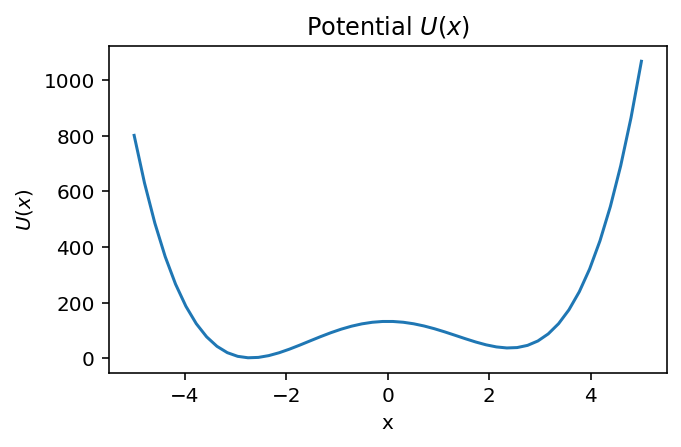

In [6]:
# plotting the Potential U(x) and the derivative dU/dx
x = np.linspace(-5,5)
fig, ax = plt.subplots(figsize=(5,3))
ax.set_title(r"Potential $U(x)$")
ax.set_xlabel("x")
ax.set_ylabel(r"$U(x)$")
ax.plot(x, U(x), label=r"$U(x)$")
plt.show()

## Simulation

Using the code shown in the previous section, a simulation is carried out with the following parameters:

- $100 \cdot 10^6$ steps
- $\Delta t = 0.001 \,\text{ps}$ 
- $\Gamma = 100$ 
- $k_B T = 38 \,\text{ps}^-1$ 
- $x(0) = v(0) = 0$ 

The number of simulation steps is twice the number indicated on the instructions for the task. However, this only results in smaller statistical errors in the later analysis. In order to use the trajectory corresponding to different intervals in later calculations, the trajectory of the simulation is saved for many different intervals, i.e. if the interval is $n$, only every $n^\text{th}$ step is saved. This is done for many more time intervals than indicated on the instructions. The main reason for that is to have the opportunity to have a look at the behaviour of the transition matrices in a wider range of lag times later on. Additionally, this results in more data points in most of the plots, which make the results easier to interpret.

In [7]:
# parameters of the simulation
n_steps = int(100e6)
delta_t = 0.001
seed_for_simulation = 5
lag_times = np.concatenate((
                    np.array([1, 2, 5, 10, 50, 100, 300, 1000, 1500, 
                              2000, 2500, 3000, 3500, 4000, 4500, 5000,
                              5500, 6000, 6500, 7000, 7500, 8000, 
                              10_000, 20_000, 30_000, 40_000]),
                    np.arange(50_000, 2_000_000, 50_000)))
# define path where to save the trajectories
path = "/Users/joschkabirk/trajectories_simphys/seed%i_steps%1.e/"%(seed_for_simulation, n_steps)
os.system("mkdir -p "+path)
# perform the simulation
sim = Markov_simulation(steps=int(n_steps), dt=delta_t, \
                        seed=seed_for_simulation)
# sim.simulate()

In [8]:
# save the trajectories
for n in lag_times:
    # save in .npy format because this is much faster than saving as 
    # .csv or .txt
    sim.save_trajectory(path+"trajectory_with_interval_%i.npy"%(n), \
                        interval=n, printing=False)

## Visualisation

The trajectory of the first $50 \cdot 10^5$ simulation steps i.e. within the first $50000$ is plotted below. The plot shows that the particle always spends some time in either the left or the right minimium of the potential until it flips to the other one. This already shows that there are two dominant states in the system corresponding to the two minima of the potential.

The second plot shows the histogram of the same trajectory. The histogram agrees pretty well with the expected shape, since we have a lower minimum located at $x\approx -2.7$ and a slightly higher minimum at $x\approx 2.4$. Therefore, a larger population is expected in the left minimum compared to the right minimum.

In [9]:
traj1 = np.load(path+"/trajectory_with_interval_1.npy")

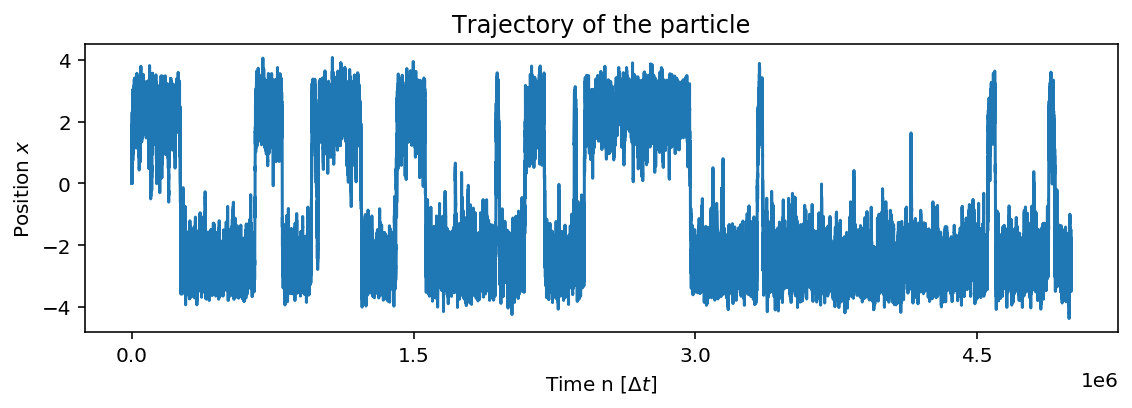

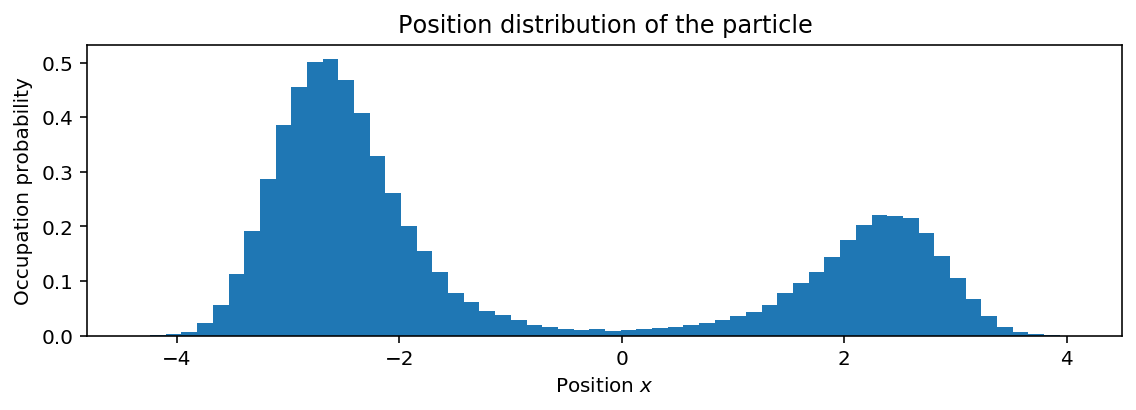

In [10]:
plot_trajectory(trajectory=traj1, end_step=int(50e5) )
occupation_probability, histo_bins = plot_histogram(trajectory=traj1,  
                                                    end_step=int(50e5), 
                                                    nbins=60 )

In order to validate the occupation probability as a function of the position $x$, the corresponding potential of mean force and which is equivalent to the free energy is calculated via

\begin{align}
    F(x) = \Delta G_\text{PMF} = - k_B T \ln(p(x)) \,.
\end{align}

Both the potential $U(x)$ and the potential of mean force (PMF) are plotted below. The two curves show very good agreement which verfies the implementation.

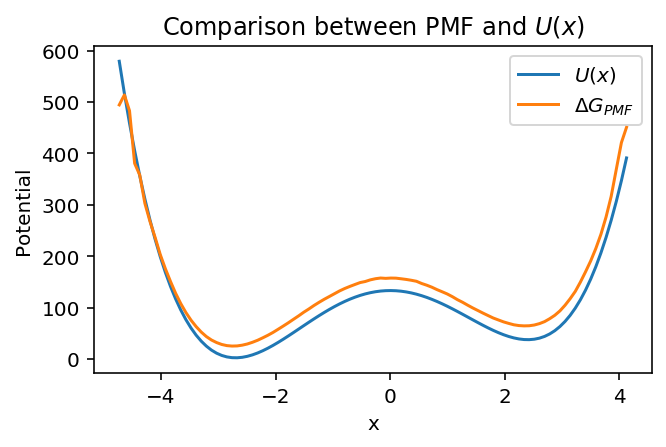

In [11]:
# get the histogram for the full trajectory -> more statistics
occupation_probability, histo_bins, p = plt.hist(traj1, bins=100, density=1)
plt.close()
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(histo_bins[:-1], U(histo_bins[:-1]), label=r"$U(x)$")
ax.plot(histo_bins[:-1], -kbT * np.log(occupation_probability), \
        label=r"$\Delta G_{PMF}$")
ax.set_title(r"Comparison between PMF and $U(x)$")
ax.set_xlabel(r"x")
ax.set_ylabel(r"Potential")
ax.legend()
plt.show()

# Calculation of Markov State Model

In order to generate a Markov State Model, two states are defined by separating the value range of $x$ into two "cores":

- core state "left" is reached for $x<-1$
- core state "right" is reached for $x>1$

The positions which lie between the core borders are always assigned to the previous state, i.e. if the particle is moving between $x=-1$ and $x=1$, but the last visited core state was "left", this state is still assigned to the "left" core until it crosses the border to the "right" core state. Since the simulation starts at $x=0$ but there is no previously visited state, the first state is randomly assigned to one of the two states. A schematic representation of these two core states is shown in the plot below.

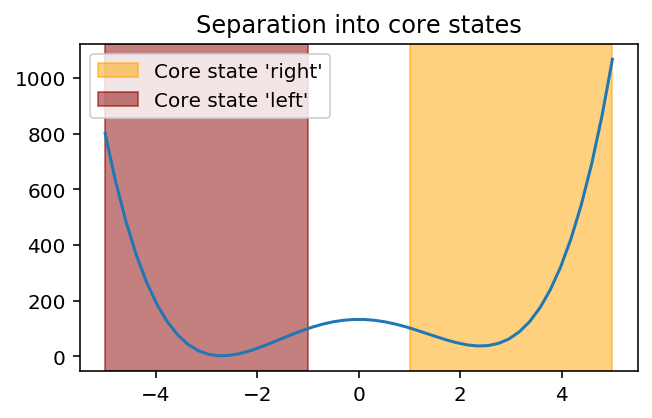

In [22]:
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(x, U(x))
ax.set_title("Separation into core states")
ax.axvspan( 1, x.max(), alpha=0.5, color="orange", label="Core state 'right'")
ax.axvspan(-1, x.min(), alpha=0.5, color="darkred",      label="Core state 'left'")
ax.legend()
plt.show()

## Transition matrices

As mentioned in the introduction, transition matrices can be used to describe the dynamics of a Markov State Model.
For two states, which is the case in this demonstration, the transition matrix $\text{M}$ is a $2 \times 2$ matrix. The entries of $\text{M}$ are the following four probabilities:

- $p_{\text{left}\rightarrow\text{right}}\left(n\Delta t\right)$ : probability of the transition "left"$\rightarrow$"right" 
- $p_{\text{left}\rightarrow\text{left}}\left(n\Delta t\right)$ : probability of remaining in "left"
- $p_{\text{right}\rightarrow\text{left}}\left(n\Delta t\right)$ : probability of the transition "right"$\rightarrow$"left" 
- $p_{\text{right}\rightarrow\text{right}}\left(n\Delta t\right)$ : probability of remaining in "right" 

These numbers depend on the so called "lag time" $n\Delta t$, which is the interval used when saving the trajectory of the simulation. The transition probability $p_{\text{left}\rightarrow\text{right}}\left(n\Delta t\right)$ is given by the formula

\begin{align}
    p_{\text{left}\rightarrow\text{right}}\left(n\Delta t\right) = 
    \frac{N_{\text{left}\rightarrow\text{right}}\left(n\Delta t\right)}{N_\text{left}\left(n\Delta t\right)} \,,
\end{align}

where $N_{\text{left}\rightarrow\text{right}}\left(n\Delta t\right)$ is the number of transitions "left"$\rightarrow$"right" observed in the trajectory and $N_\text{left}\left(n\Delta t\right)$ is the total number of steps the system was in state "left". The so-called "self-transition" probability $p_{\text{left}\rightarrow\text{left}}\left(n\Delta t\right)$ is then simply given by

\begin{align}
    p_{\text{left}\rightarrow\text{left}}\left(n\Delta t\right) = 1 - p_{\text{left}\rightarrow\text{right}}\left(n\Delta t\right) \,.
\end{align}

The other two entries of M are calculated the same way by interchanging "left" and "right" in the indices.
The resulting transition matrix corresponding to a lag time of $n\Delta t$ is then given by

\begin{align}
    \text{M}\left(n\Delta t\right) = 
    \left( \begin{array}{rr}
               p_{\text{left}\rightarrow\text{left}}\left(n\Delta t\right)  & p_{\text{left}\rightarrow\text{right}}\left(n\Delta t\right) \\
               p_{\text{right}\rightarrow\text{left}}\left(n\Delta t\right)  & p_{\text{right}\rightarrow \text{right}}\left(n\Delta t\right) \\
\end{array}\right)  =
\left( \begin{array}{rr}
               p_{-1-1}\left(n\Delta t\right)  & p_{-11}\left(n\Delta t\right) \\
               p_{1-1}\left(n\Delta t\right)  & p_{11}\left(n\Delta t\right) \\
\end{array}\right) 
\,,
\end{align}

where for simplicity the state "left" is just called "-1" and the state "right" is called "1". This convention is used in the following.

The transition matrix can be applied to a "probability vector" $\left(a~~b\right)$, where $a$ is the probability that the system is in the state $-1$ and $b$ the probability for state $1$. The way the transition matrix is defined here, this is a row vector. Multiplying this vector with $\text{M}$ yields the new probability vector after the time $n\Delta t$.

\begin{align*}
    \left(a~~~b\right) \cdot\text{M}\left(n\Delta t\right) &= \left(a~~b\right) \cdot
                            \left( \begin{array}{rr}
                               p_{-1-1}\left(n\Delta t\right)  & p_{-11}\left(n\Delta t\right) \\
                               p_{1-1}\left(n\Delta t\right)  & p_{11}\left(n\Delta t\right) \\
                            \end{array}\right) \\\\
                       &= ( 
                           \underbrace{
                             a\cdot p_{-1-1}\left(n\Delta t\right)
                           + b\cdot p_{1-1}\left(n\Delta t\right)}_
                               {a\left(n\Delta t\right)}~~~
                            \underbrace{
                             a\cdot p_{-11}\left(n\Delta t\right)
                           + b\cdot p_{11}\left(n\Delta t\right)}_
                               {b\left(n\Delta t\right)}
                          ) \\ \\
                       &= \left(a\left(n\Delta t\right) ~~~ b\left(n\Delta t\right)\right)
\end{align*}

### Calculation of the transition matrices

In order to calculate the transition matrices for different lag times, the trajectory is first translated into an array just consisting of the values $-1$ and $1$ corresponding to "left" and "right" for each step. Afterwards, the corresponding probabilities are calculated. This is done with the function $\texttt{calculate\_states\_and\_M()}$ which is shown in the second section. The function takes a trajectory as input, translates this trajectory into an array of states and then calculates the transition matrix. The returned objects are the transition matrix and the states array.

The function $\texttt{load\_traj\_and\_calc\_M()}$ performs this calculation, i.e. loads the trajectory and calls the function $\texttt{calculate\_states\_and\_M()}$ for all lag times. The trajectories, the transition matrices and the state arrays are stored in dictionaries with the lag time being the key of each item. This makes the code of some later calculations much easier to read compared to when storing them in a list or array. These dictionaries are returned by the function $\texttt{load\_traj\_and\_calc\_M()}$.

In [23]:
transition_matrices, trajectories, states = load_traj_and_calc_M(path, lag_times)

# Validation of Markov State Model

In order to be a valid MSM, the matrix $\text{M}(n\Delta t)$ must fulfill the condition 
\begin{equation}
    \text{M}(m \cdot n \Delta t) = \text{M}(n \Delta t)^m \,.
\end{equation}

This condition basically means that the probabilities for finding the system in either state $-1$ or $1$ after a time $m \,n\, \Delta t$ can be either calculated by "applying one large transition with lag time $m \,n\, \Delta t$" or by "applying $m$ times a transition of a short(er) lag time $n\, \Delta t$". This represents the idea of a system with no memory since the probabilities after a given time do not depend on what happend in between.

## Explicit verification

The condition above can be checked explicitly by building the $m$-fold product of $\text{M}(n \Delta t)$ with itself and compare it with the corresponding matrix $\text{M}(m \cdot n \Delta t)$. Below this is done in different ways. First, two cases of simply squaring the transition matrix are compared as well as two cases in which a $10$-fold matrix product is considered. These cases are:

- for $m=2$:
    \begin{align}
        \text{M}(2 \cdot 1 \Delta t) &\overset{?}{ =} \text{M}(1 \Delta t)^2  \\
        \text{M}(2 \cdot 1000 \Delta t) &\overset{?}{ =} \text{M}(1000 \Delta t)^{2} 
    \end{align}
- for $m=10$:
    \begin{align}
        \text{M}(10 \cdot 5 \Delta t) &\overset{?}{ =} \text{M}(5 \Delta t)^{10}  \\
        \text{M}(10 \cdot 10 \Delta t) &\overset{?}{ =} \text{M}(10 \Delta t)^{10} 
    \end{align}
    
In the cell below, the result of these four equations is printed. Since the absolut values of the difference between the matrix entries are more difficult to interpret, the relative difference of $\text{M}(n \Delta t)^m$ and $\text{M}(m \cdot n \Delta t)$ is printed.

In [24]:
np.set_printoptions(precision=5)

print("two cases with m=2:", "\n")
print("Relative difference between M(Δt)^2 and M(2Δt)")
print(np.linalg.matrix_power(transition_matrices["1"],2) \
      / transition_matrices["2"] - 1, "\n")
print("Relative difference between M(1000Δt)^2 and M(2000Δt)")
print(np.linalg.matrix_power(transition_matrices["1000"],2) \
      / transition_matrices["2000"] - 1, "\n")

print(30*"-", 2*"\n", "two cases with m=10:", "\n")
print("Relative difference between M(5Δt)^10 and M(50Δt)")
print(np.linalg.matrix_power(transition_matrices["5"],10) \
      / transition_matrices["50"] - 1, "\n")
print("Relative difference between M(10Δt)^10 and M(100Δt)")
print(np.linalg.matrix_power(transition_matrices["10"],10) \
      / transition_matrices["100"] - 1, "\n")

two cases with m=2: 

Relative difference between M(Δt)^2 and M(2Δt)
[[ 9.70306e-11 -9.14900e-06]
 [-1.03047e-05  2.81565e-10]] 

Relative difference between M(1000Δt)^2 and M(2000Δt)
[[-0.00029  0.03263]
 [ 0.03267 -0.00076]] 

------------------------------ 

 two cases with m=10: 

Relative difference between M(5Δt)^10 and M(50Δt)
[[-3.39138e-06  1.29589e-02]
 [ 1.25007e-02 -8.43560e-06]] 

Relative difference between M(10Δt)^10 and M(100Δt)
[[-2.04506e-05  4.01276e-02]
 [ 3.96178e-02 -5.20857e-05]] 



This test is actually quite hard, because all of these differences are pretty small. In all cases the relative difference in the off-diagonal entries, i.e. the transition probabilities to the other state are much larger than the relative difference in the self-transition probabilities. 

At first glance the result for $n=1$ and $m=2$ (first printout) seems much better than for $n=1000$ and $m=2$ (second printout) because the difference to the transition matrix corresponding to the direct transition is much smaller in the first case even though both prinouts show the case of simply squaring the matrix. However, this can not be compared like that because the total lag time represented by the two different cases differs by a factor of $2000$. This also shows up for the case where the $10$-fold matrix product is compared at different lag times (third and fourth printout).

A much more reasonable comparison would be to compare two cases that represent the same total lag time. In order to do that, the following cases are printed below:

- for the lag time $100 \Delta t$:
    \begin{align}
        \text{M}(100 \cdot 1 \Delta t)&\overset{?}{=}\text{M}(1 \Delta t)^{100} \\
        \text{M}(10 \cdot 10 \Delta t)&\overset{?}{=}\text{M}(10 \Delta t)^{10}
    \end{align}
    
- for the lag time $2000 \Delta t$:
    \begin{align}
        \text{M}(20 \cdot 100 \Delta t)&\overset{?}{=}\text{M}(100 \Delta t)^{20} \\
        \text{M}(2 \cdot 1000 \Delta t)&\overset{?}{=}\text{M}(1000 \Delta t)^{2} 
    \end{align}

In [25]:
print("two cases with lag time 100Δt:", "\n")
print("Relative difference between M(1Δt)^100 and M(100Δt)")
print(np.linalg.matrix_power(transition_matrices["1"],100) \
      / transition_matrices["100"] -1, "\n")
print("Relative difference between M(10Δt)^10 - M(100Δt)")
print(np.linalg.matrix_power(transition_matrices["10"],10) \
      / transition_matrices["100"] -1, "\n")

print(30*"-", 2*"\n", "two cases with lag time 2000Δt:", "\n")
print("Relative difference between M(100Δt)^20 and M(2000Δt):")
print(np.linalg.matrix_power(transition_matrices["100"],20) \
      / transition_matrices["2000"] -1, "\n")
print("Relative difference between M(1000Δt)^2 and M(2000Δt): ")
print(np.linalg.matrix_power(transition_matrices["1000"],2) \
      / transition_matrices["2000"] -1)

two cases with lag time 100Δt: 

Relative difference between M(1Δt)^100 and M(100Δt)
[[-2.04060e-05  4.00401e-02]
 [ 3.95265e-02 -5.19657e-05]] 

Relative difference between M(10Δt)^10 - M(100Δt)
[[-2.04506e-05  4.01276e-02]
 [ 3.96178e-02 -5.20857e-05]] 

------------------------------ 

 two cases with lag time 2000Δt: 

Relative difference between M(100Δt)^20 and M(2000Δt):
[[-0.00125  0.14169]
 [ 0.14111 -0.00327]] 

Relative difference between M(1000Δt)^2 and M(2000Δt): 
[[-0.00029  0.03263]
 [ 0.03267 -0.00076]]


The first comparison does not show much of a difference between taking the $100$-fold product of $\text{M}(1\Delta t)$ and taking the $10$-fold product of $\text{M}(10\Delta t)$. However, the second comparison, which considers a transition with lag time $2000\,\Delta t$ shows a significant improvement when using only the $2$-fold product of $\text{M}(1000\Delta t)$ instead of the $20$-fold product of $\text{M}(100\Delta t)$. The relative difference to the reference matrix $\text{M}(2000\Delta t)$ is by a factor of 5 smaller when using 
This indicates already, that the criteria for a valid MSM is rather fulfilled when using matrices corresponding to higher lag times.

To do this in a more general way instead of just calculating a few examples, one needs to compare for each fixed lag time $n_\text{fixed} \Delta t$ the different matrix products $\text{M}(n \Delta t)^m$ where $m = n_\text{fixed} / n$, i.e. all the different "ways" corresponding to a transition with total lag time $n_\text{fixed} \Delta t$ have to be compared. 
If the system is Markovian, then all these different "ways" have to be the same because then the probabilities do not change if the transition is carried out over many short transitions instead of one transition covering the whole lag time $n_\text{fixed} \Delta t$.
This comparison is done in the following using the function $\texttt{check\_MS\text{M}()}$ which can be seen in the code in Section 2.

The function produces a plot with 4 subplots that represent the four different matrix elements of the transition matrix. The $x$-axis shows the lag time in the form of $n_\text{fixed}$ (so the lag time is given in multiples of $\Delta t$) and the $y$-axis shows the value of the entry in the transition matrix. The black curve shows the transition matrix that corresponds to a "direct" transition, i.e. $\text{M}(n_\text{fixed} \Delta t)$, which is the reference line. For each lag time $n_\text{fixed} \Delta t$, there are several additional points drawn on the $y$-axis in different colours. These points represent the matrix entries of the diffent $m$-fold matrix products $\text{M}(n\Delta t)^m$ that lead to the same lag time , i.e. the exponent $m$ is always chosen in a way that $m \cdot n = n_\text{fixed}$. For example for the lag time corresponding to $n_\text{fixed} = 10$ there are three additional points in the plots which show the matrix elements of $\text{M}(1\Delta t)^{10}$, $\text{M}(2\Delta t)^5$ and $\text{M}(5\Delta t)^2$. For larger lag times there are many more possible products of transition matrices that correspond to that lag time so there are many more points in the graph.

The code loops over all lag times $\texttt{n\_fixed}$ that are considered in this example (up to $n_\text{fixed}=8000$, then loops again over all lag times to find the lag times in the list that are shorter than $\texttt{n\_fixed}$. If $\texttt{n\_fixed}$ can be written as the product of $n$ and some other integer $m$, the matrix entries of $\text{M}(n\Delta t)^m$ are stored in a numpy array. The rest of the code is just the plotting.

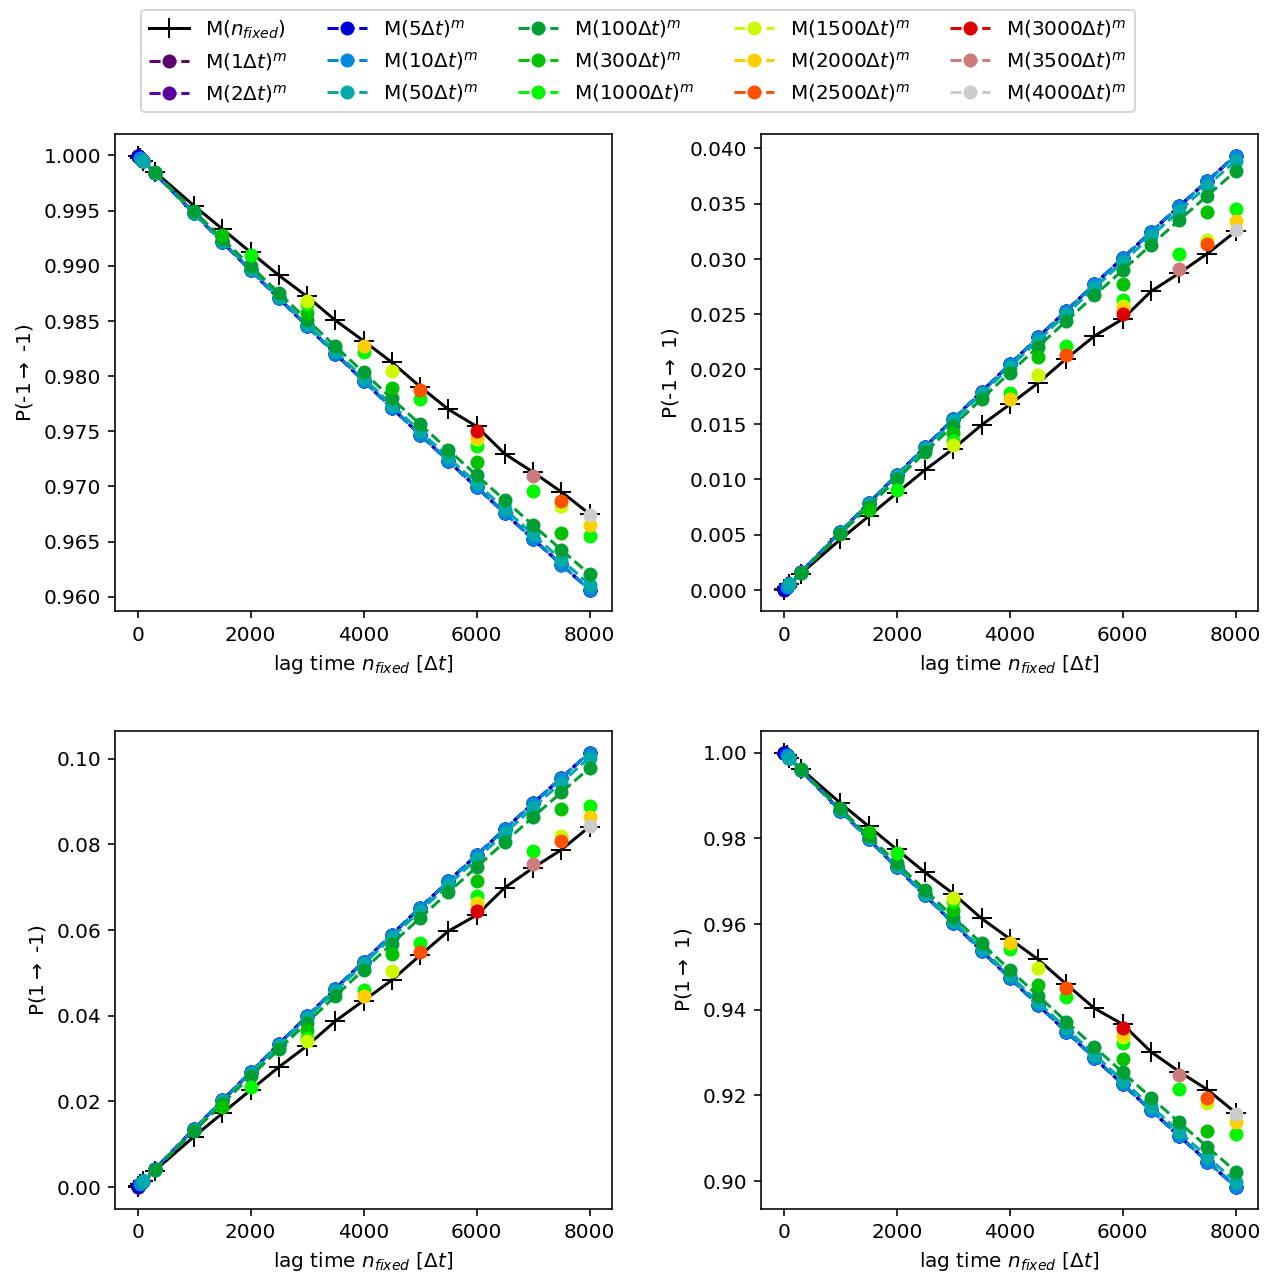

In [17]:
lag_times_explicit = np.array([1, 2, 5, 10, 50, 100, 300, 1000, 1500, 2000, \
                               2500, 3000, 3500, 4000, 4500, 5000, 5500, \
                               6000, 6500, 7000, 7500, 8000])
check_MSM(lag_times_explicit, transition_matrices)

The resulting plot is shown above. Note that for large values of $n$ there are only very few points in the graph since the criteria $n_\text{fixed}=m\cdot n$ is only fulfilled for very few values of $n_\text{fixed}$. So for $n=2000$ for example, the plot only shows 3 points which are located at $n_\text{fixed}=4000$, $n_\text{fixed}=6000$ and $n_\text{fixed}=8000$.

The plot of the entries of the different matrices makes it possible to estimate the minimal lag time $n_0$ to generate a valid MSM. This can be done by looking for the minimum $n$ (corresponding to one colour in the plots) for which the matrix element is agreeing with the black reference line even at long lag times. While the curves for $n < 1000$ (blue and dark green lines) are quite far away from the black reference curve, there is quite an improvement in the light green lines corresponding to $n=1000$ and $n=1500$. 

The coloured points get quite close to the reference curve for $n>2000$ (redish points) which is why the minimal $n_0$ to generate a valid MSM is estimated to be $n_0=2500$. However, the estimation with this method is quite hard because it is possible that when having a look at lag times that are much longer than the maximum $n_\text{fixed}=8000$ considered here differences start to show up for the values of $n$ which agree with the reference curve here. In order to cover a larger range of total lag times, the previous plot is also produced for lag times up to $n_{fixed}= 1\,000\,000$. This also allows to have a look at the stationary state of the system.

## Stationary probability vector

All transition matrices have a stationary state, which means that the state is not changed by applying a transition matrix to the vector. This stationary state is an eigenvector of the transition matrix, which is why the eigenvalues and eigenvectors of transition matrices are briefly discussed in the following.

### Eigenvalues of transition matrices

A general transition matrix for a two state system can be simply written as 

\begin{align}
    M =
    \left( 
        \begin{array}{cc}
               \alpha  & 1-\alpha \\
               1-\beta  & \beta \\
        \end{array}
    \right)
\end{align}
with $\alpha, \beta \in [0, 1]$, which has the eigenvalues
\begin{align}
    \lambda_0 = 1 ~~~\text{and}~~~ \lambda_1= \alpha + \beta -1 \,.
\end{align}

Note that since $\alpha\leq 1$ and $\beta \leq 1$ the second eigenvalue is limited by $\lambda_1 \leq 1$. As $\alpha = 1= \beta \leq 1$ would mean that the transition matrix is the identity and hence there are absolutely no dynamics in the system, this eigenvalue is assumed to be smaller than one in the following. 

### Calculation of the stationary probability vector

Since the transition matrix $\text{M}$ can be diagonalised, its action on a probability vector $\vec{\pi}$ can be splitted into the action of the two eigenvectors $\vec{u}_0$ and $\vec{u}_1$ with eigenvalues $\lambda_0$ and $\lambda_1$. To do so, the vector $\vec{\pi}$ is written as a linear combination of the two eigenvectors $\vec{u}_0$ and $\vec{u}_1$ as 

\begin{align*}
    \vec{\pi} = c_0 \vec{u}_0 + c_1 \vec{u}_1
\end{align*}

with $c_0$, $c_1$ $\in \mathbb{R}$. It is easy to show that the eigenvector $\vec{u}_1$ has the form $\vec{u}_1 = (-z ~~z)$ with $z \in \mathbb{R}$. The normalisation of the eigenvector $\vec{u}_0$ is chosen such that its entries sum up to 1. Since $\vec{\pi}$ is a statistical vector, its entries also have to sum up to 1, which leads to

\begin{align*}
    1 &= c_0 \cdot u_{01} + c_0 \cdot u_{02} + c_1 \cdot (-z) + c_1 \cdot z \\\\
      &= c_0 \cdot u_{01} + c_0 \cdot u_{02} = c_0 \cdot (\underbrace{u_{01} + u_{02}}_{=1}) ~~~\Rightarrow ~~~ c_0=1
\end{align*}
Using this, the change of $\vec{\pi}$ with repreatedly applying the transition matrix can be calculated

\begin{align*}
    \vec{\pi} \cdot \text{M}^m &= (\vec{u}_0 + c_1 \vec{u}_1) \cdot \text{M}^m = 
             \vec{u}_0\cdot \text{M}^m + c_1 \vec{u}_1\cdot \text{M}^m \\\\
            &= \vec{u}_0\cdot \underbrace{\lambda_0^m}_{=1} + c_1 \vec{u}_1\cdot \lambda_1^m
             = \vec{u}_0 + \underbrace{c_1 \vec{u}_1\cdot \lambda_1^m}_\text{decaying} \,.
\end{align*}

As $\lambda_1$ is smaller than 1, this converges with an exponential decay towards the eigenvector $\vec{u}_0$.
In terms of the the transition matrix, this means than $\text{M}^m$ converges to

\begin{align}
\text{M}^m \overset{m \text{ to } \infty}{\rightarrow}
    \left( \begin{array}{rr}
               u_{01}  & u_{02} \\
               u_{01}  & u_{02} \\
    \end{array}\right) \,.
\end{align}

This convergence is shown in the following. The function used for that, $\texttt{plot\_M\_limes()}$ is quite similar to the function $\texttt{check\_MSM()}$ besides the fact that the matrix products are calculated for much larger lag times here.

The plot below shows the resulting plots for the evolution of the matrix elements of the matrix products $\text{M}(n \Delta t)^m$ for different $n_\text{fixed} = n \cdot m$. Note that the $x$-axis of the plot is in logarithmic scale. The matrix elements show very good agreement with the expected exponential decay for the two diagonal elements (upper left and lower right plot). The black reference points which correspond to $\text{M}(n_\text{fixed} \Delta t)$ start to fluctuate quite strongly for very large lag times. However, this is due to the fact that the trajectories corresponding to these large lag times have very low statistics. 

The middle of the plot shows again that the coloured lines agree quite well with the reference points for $n\geq2500$, which shows again that this is a good estimate for the minimal lag time needed to produce a valid MSM.

The blue lines in the four plots show the entries of the eigenvector $\vec{u}_0 = (0.72, 0.28)$ which are the values the matrix entries $M_{-1-1}$ and $M_{1-1}$ are expected to converge to. The matrix elements agree quite well with the expected values for large lag times. This means that for large timescales, the transition probability to state $-1$ is around $0.72$ and the transition probability to the state $1$ is $0.28$.

In [18]:
M = transition_matrices["10000"]
# calculate the eigenvector of M.transpose because numpy
# uses calculates a column-eigenvector, not rows
eigenvals, eigenvecs = np.linalg.eig(M.T)
u0 = eigenvecs[:,0]
# check that u0 is a probability vector (entries sum up to 1)
u0 = u0 / u0.sum()
print("'normalised' u0:", u0)
print("u0 * M", np.dot(u0.T, M))
print("--> this is the stationary state")

'normalised' u0: [0.72083 0.27917]
u0 * M [0.72083 0.27917]
--> this is the stationary state


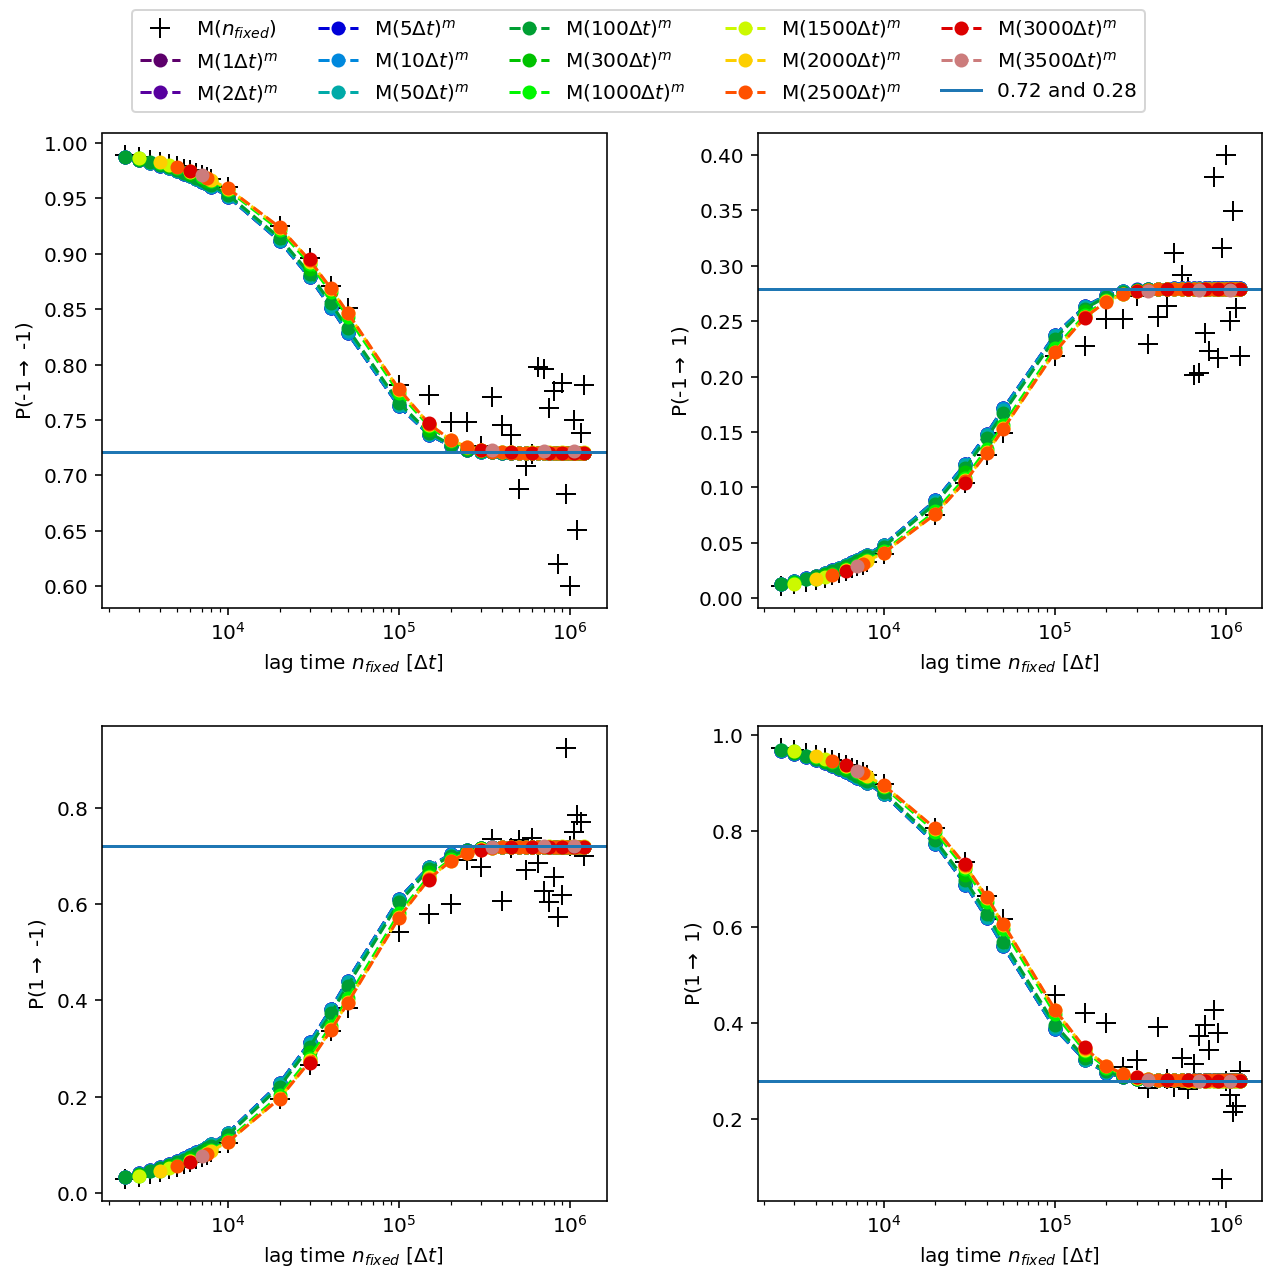

In [38]:
plot_M_limes(lag_times[:-15], transition_matrices, u01=u0[0], \
             u02=u0[1], max_n_index=13, x_axis_start_n=10)

## Validation of the Markov State Model using the implied timescale

Another much easier and more robust way to validate a Markov State Model is the calculation of the so-called *implied timescale*. This method uses the properties of the eigenvalues of the transition matrix.

Considering again the condition stated in the previous section, $\text{M}(m \cdot n \Delta t) = \text{M}(n \Delta t)^m$ but now with the diagonal matrices leads to

\begin{align}
    \text{M}(m \cdot n \Delta t) = \text{M}(n \Delta t)^m
    ~~\Rightarrow~~
    \left( 
        \begin{array}{cc}
               \lambda_0(m \cdot n \Delta t)   & 0 \\
               0  & \lambda_1(m \cdot n \Delta t)  \\
        \end{array}
    \right) =
    \left( 
        \begin{array}{cc}
               \lambda_0(n \Delta t)^m   & 0 \\
               0  & \lambda_1(n \Delta t)^m  \\
        \end{array}
    \right) \,.
\end{align}

Since $\lambda_0 = 1$ for all lag times, this means that for a markovian process the eigenvalues $\lambda_1$ of different lag times fulfill

\begin{align}
    \lambda_1(m \cdot n \Delta t) = \lambda_1(n \Delta t)^m \,.
\end{align}

### Calculation and evaluation of the implied timescale

Using this relation, the validation of a MSM can be performed much easier than done in the previous section. To do so the *implied timescale* is calculated which is defined as 

\begin{align}
    t(n \,\Delta t) = - \frac{n\,\Delta t}{\ln(\lambda_1(n\,\Delta t))} \,.
\end{align}

The implied timescale has the useful property that is is constant for a valid MSM. This is easily shown by using the relation $\lambda_1(m \cdot n \Delta t) = \lambda_1(n \Delta t)^m$, which leads to

\begin{align}
    t(m \cdot n \,\Delta t) = - \frac{m\cdot n\,\Delta t}{\ln(\lambda_1(m \cdot n\,\Delta t))} =
    - \frac{m\cdot n\,\Delta t}{\ln\left(\lambda_1(n\,\Delta t)^m\right)} = 
    - \frac{m\cdot n\,\Delta t}{m \cdot \ln\left(\lambda_1(n\,\Delta t)\right)} =
    t(n \,\Delta t) \,.
\end{align}

So in order to check for the minimal $n_0$ to generate a valid MSM, one can just calculate the implied timescale as a function of the lagtime and estimate $n_0$ by looking for which lagtime the implied timescale becomes constant. These calculations are performed using the function $\texttt{implied\_timescale\_evolution()}$ shown in Section 2.

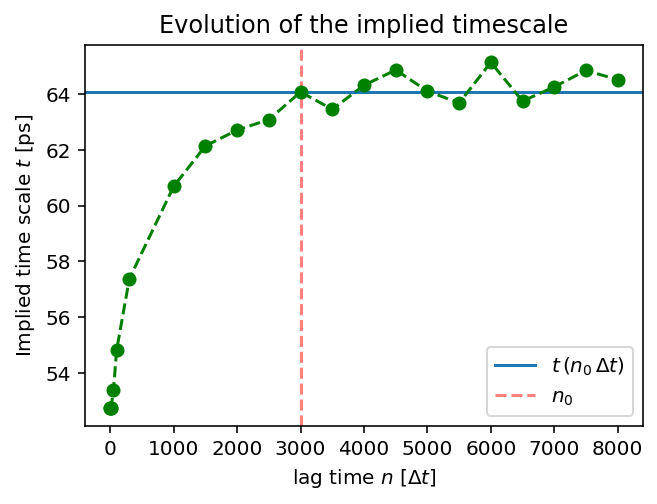

In [30]:
lag_times_imp_timescale = [1, 2, 5, 10, 50, 100, 300, 1000, 1500, 2000, 2500, \
                           3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000]
implied_timescale_evolution(transition_matrices, lag_times_imp_timescale)

The results for the example calculated here are shown in the plot above. The implied timescale $t$ becomes quite constant for lag times $n \geq3000$. This $n_0 = 3000$ is slightly larger than the value estimated with the explicit comparison of the matrix elements, which is $2500$.

There are also still some fluctuations in the implied timescale for $n>n_0$. These fluctuations are due to the fact, that the number of transitions happening here is at the scale of a few hundred transitions, which can lead to significant fluctuations in the implied timescale. 

## Results for different seeds in the np.random module

Even though the plot of the implied timescale looks quite nice in terms of convergence to a constant value, it should be stated, that this plot looks quite different for different seeds chosen in at the beginning of the simulation.

Simulations were performed with different seeds and the resulting plots of the implied timescale are briefly discussed here. The used seeds are $1, 5, 42$ and $100$. The trajectories are loaded from previous simulations and the calculations are performed the same way as above.

In [31]:
path1   = "/Users/joschkabirk/trajectories_simphys/seed1_steps1e+08/"
path5   = "/Users/joschkabirk/trajectories_simphys/seed5_steps1e+08/"
path42  = "/Users/joschkabirk/trajectories_simphys/seed42_steps1e+08/"
path100 = "/Users/joschkabirk/trajectories_simphys/seed100_steps1e+08/"

In [33]:
lag_times_imp_timescale = [1, 2, 5, 10, 50, 100, 300, 1000, 1500, 2000, 2500, \
                           3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500]

In [34]:
transition_matrices1,   trajectories1,   states1   = load_traj_and_calc_M(path1, lag_times_imp_timescale)
transition_matrices5,   trajectories5,   states5   = load_traj_and_calc_M(path5, lag_times_imp_timescale)
transition_matrices42,  trajectories42,  states42  = load_traj_and_calc_M(path42, lag_times_imp_timescale)
transition_matrices100, trajectories100, states100 = load_traj_and_calc_M(path100, lag_times_imp_timescale)

In [ ]:
print("with seed=1:")
implied_timescale_evolution(transition_matrices1, lag_times_imp_timescale)
print("with seed=5:")
implied_timescale_evolution(transition_matrices5, lag_times_imp_timescale)
print("with seed=42:")
implied_timescale_evolution(transition_matrices42, lag_times_imp_timescale)
print("with seed=100:")
implied_timescale_evolution(transition_matrices100, lag_times_imp_timescale)

This comparison shows that the estimation of the minimal lag time $n_0$ can even be quite hard when using the implied timescale since the graph produced with the trajectory corresponding to seed $42$ does not really look like the graph is converged. However, as stated before, the number of transitions in these simulations is quite smalle, which can mean that these differences are the result of undersampling.

# Summary

This project demonstrated the construction and validation of a Markov State Model. By using a simple double well potential and the Markovian Langevin Equation, a simulation was carried out in order to simulate the trajectory of a one-dimensional particle moving in this potential. By defining two core states along the position value range, the transition matrix of the system was calculated for a variety of different lag times. These transition matrices were then used to analyse at which lag time $n_0$ the system becomes a valid Markov State Model.

This estimation was performed in two different ways. First, the estimation was done by explicity comparing the matrix entries of different matrix products corresponding to the same lag time, resulting in

\begin{align*}
    n_{0, \text{explicit}} = 2500 \,.
\end{align*}

However, this method is not as easy to visualise and not as robust as the second method used here, which exploits the properties of the transition matrix under diagonalisation. Due to the relation between the eigenvalues of transition matrices calculated at different lag times, the implied timescale of a system becomes constant for a MSM. Hence, by calculating the implied timescale of the system at different lag times, the minimal lag time for a MSM could be estimated much easier. The result found with this method is

\begin{align*}
    n_{0, \text{imp.time}} = 3000 \,,
\end{align*}

which is slightly larger than the value estimated with the first method. However, this method is much more robust and easier to use which is why this estimation of $n_0$ is chosen as the final result. Additionally, some studies were performed by running simulations with different seeds in the random numbers generator used in the simulation. The resulting datasets showed quite some differences, which shows that the estimation of the minimal lag time $n_0$ is non-trivial.